In [17]:
import pandas as pd

df = pd.read_excel("C:/Users/faisa/Aviemore 2010.xlsx", sheet_name="AVIEMORE")

df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

print("Data loaded successfully!")
print("Columns:", df.columns.tolist())
print(df.head())



Data loaded successfully!
Columns: ['day', 'month', 'year', 'time_(gmt/utc)', 'wind_-_mean_speed_(knots)', 'wind_-_mean_direction']
   day  month  year  time_(gmt/utc)  wind_-_mean_speed_(knots)  \
0    1      1  2010               0                        1.0   
1    1      1  2010               1                        1.0   
2    1      1  2010               2                        1.0   
3    1      1  2010               3                        2.0   
4    1      1  2010               4                        3.0   

   wind_-_mean_direction  
0                  200.0  
1                  230.0  
2                  200.0  
3                  230.0  
4                  330.0  


In [18]:
import pandas as pd
import numpy as np


df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]


df['wind_mean_speed_ms'] = df['wind_-_mean_speed_(knots)'] * 0.51444

df['datetime'] = pd.to_datetime(
    df[['year', 'month', 'day', 'time_(gmt/utc)']].rename(columns={'time_(gmt/utc)': 'hour'})
)

df.head()


,day,month,year,time_(gmt/utc),wind_-_mean_speed_(knots),wind_-_mean_direction,wind_mean_speed_ms,datetime
0,1,1,2010,0,1.0,200.0,0.51444,2010-01-01 00:00:00
1,1,1,2010,1,1.0,230.0,0.51444,2010-01-01 01:00:00
2,1,1,2010,2,1.0,200.0,0.51444,2010-01-01 02:00:00
3,1,1,2010,3,2.0,230.0,1.02888,2010-01-01 03:00:00
4,1,1,2010,4,3.0,330.0,1.54332,2010-01-01 04:00:00


In [19]:
import numpy as np

bins = np.arange(0, 31, 1)
df['speed_bin'] = pd.cut(df['wind_mean_speed_ms'], bins=bins, right=False)

speed_freq = df['speed_bin'].value_counts().sort_index()
speed_freq = (speed_freq / speed_freq.sum()) * 100  # Convert to %
speed_freq


speed_bin
[0, 1)      22.727273
[1, 2)      28.962997
[2, 3)      21.379625
[3, 4)      13.487894
[4, 5)       7.320694
[5, 6)       3.460484
[6, 7)       1.553221
[7, 8)       0.593878
[8, 9)       0.331201
[9, 10)      0.125628
[10, 11)     0.034262
[11, 12)     0.022841
[12, 13)     0.000000
[13, 14)     0.000000
[14, 15)     0.000000
[15, 16)     0.000000
[16, 17)     0.000000
[17, 18)     0.000000
[18, 19)     0.000000
[19, 20)     0.000000
[20, 21)     0.000000
[21, 22)     0.000000
[22, 23)     0.000000
[23, 24)     0.000000
[24, 25)     0.000000
[25, 26)     0.000000
[26, 27)     0.000000
[27, 28)     0.000000
[28, 29)     0.000000
[29, 30)     0.000000
Name: count, dtype: float64


 Site Parameters:
   Surface roughness (z0): 0.25 m
   Reference height above ground: 10 m
   Reference altitude (ASL): 228 m
   Absolute altitude of measurement: 238 m ASL

 Weibull Parameters at 10m height (228m ASL):
   Weibull shape (k): 1.43
   Weibull scale (A): 2.35
   Mean wind speed: 2.113 m/s

Weibull Scale (A) adjusted to different heights:
   (using z0 = 0.25m, k = 1.43)
   Reference site: 228m ASL

   Height Above    Absolute        Scale A      Mean Wind
   Ground (m)      Altitude (ASL)  (m/s)        Speed (m/s)
   -----------------------------------------------------------------
       80             308            3.671        3.335
      100             328            3.813        3.464
      120             348            3.929        3.569
      155             383            4.092        3.717


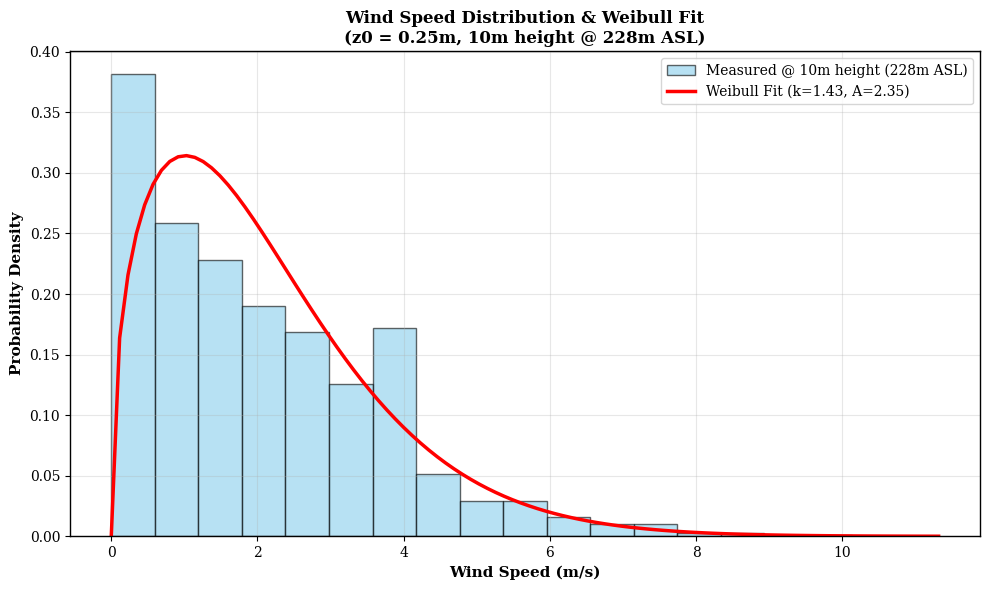

   Measurements taken at: 10m height, 228m altitude (ASL)


In [24]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


z0 = 0.25  
reference_height = 10  
reference_altitude = 228  


print(f"\n Site Parameters:")
print(f"   Surface roughness (z0): {z0} m")
print(f"   Reference height above ground: {reference_height} m")
print(f"   Reference altitude (ASL): {reference_altitude} m")
print(f"   Absolute altitude of measurement: {reference_altitude + reference_height} m ASL")


data = df['wind_mean_speed_ms'].dropna()
shape, loc, scale = weibull_min.fit(data, floc=0)

print(f"\n Weibull Parameters at {reference_height}m height ({reference_altitude}m ASL):")
print(f"   Weibull shape (k): {shape:.2f}")
print(f"   Weibull scale (A): {scale:.2f}")
print(f"   Mean wind speed: {data.mean():.3f} m/s")


def adjust_weibull_scale_to_height(A_ref, z_ref, z_target, z0, k):

    A_target = A_ref * (np.log(z_target / z0) / np.log(z_ref / z0))
    return A_target


example_hub_heights = [80, 100, 120, 155]
print(f"\nWeibull Scale (A) adjusted to different heights:")
print(f"   (using z0 = {z0}m, k = {shape:.2f})")
print(f"   Reference site: {reference_altitude}m ASL")
print(f"\n   Height Above    Absolute        Scale A      Mean Wind")
print(f"   Ground (m)      Altitude (ASL)  (m/s)        Speed (m/s)")
print(f"   " + "-"*65)

from scipy.special import gamma
for hub_height in example_hub_heights:
    A_hub = adjust_weibull_scale_to_height(scale, reference_height, hub_height, z0, shape)
    # Mean wind speed for Weibull = A * Gamma(1 + 1/k)
    mean_wind = A_hub * gamma(1 + 1/shape)
    abs_altitude = reference_altitude + hub_height
    print(f"   {hub_height:6.0f}          {abs_altitude:6.0f}          {A_hub:7.3f}      {mean_wind:7.3f}")


plt.figure(figsize=(10, 6))
bins = 19 

# Plot measured data
plt.hist(data, bins=bins, density=True, color='skyblue', edgecolor='k', 
         alpha=0.6, label=f'Measured @ {reference_height}m height ({reference_altitude}m ASL)')

# Plot Weibull fit
x = np.linspace(0, data.max(), 100)
plt.plot(x, weibull_min.pdf(x, shape, loc, scale), 'r-', lw=2.5, 
         label=f'Weibull Fit (k={shape:.2f}, A={scale:.2f})')

plt.xlabel('Wind Speed (m/s)', fontweight='bold', fontsize=11)
plt.ylabel('Probability Density', fontweight='bold', fontsize=11)
plt.title(f'Wind Speed Distribution & Weibull Fit\n(z0 = {z0}m, {reference_height}m height @ {reference_altitude}m ASL)', 
          fontweight='bold', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



print(f"   Measurements taken at: {reference_height}m height, {reference_altitude}m altitude (ASL)")


   Reference height above ground: 10m
   Reference altitude (ASL): 228m
   Farm altitude (ASL): 437m
   Altitude difference: 209m
   Mean wind speed: 2.113 m/s
   Surface roughness: z0 = 0.25m

 Air Density Effects:
   Temperature at reference: 286.67 K (13.5°C)
   Air density at reference: 1.1922 kg/m³
   Temperature at farm: 285.31 K (12.2°C)
   Air density at farm: 1.1628 kg/m³
   Air density correction: 0.975330
   Power loss from density: -2.47%

 Wind Speed Scenario: (no wind change)
   Wind speed factor: 1.000000
   v_ref at farm altitude: 2.113 m/s (vs 2.113 m/s at reference)

Height Above Ground       Absolute Altitude (ASL)   Wind Speed (m/s)     Increase from Ref        
-----------------------------------------------------------------------------------------------
10m                      447m                     2.113                (reference)              
30m                      467m                     2.743                +29.8%                   
50m                

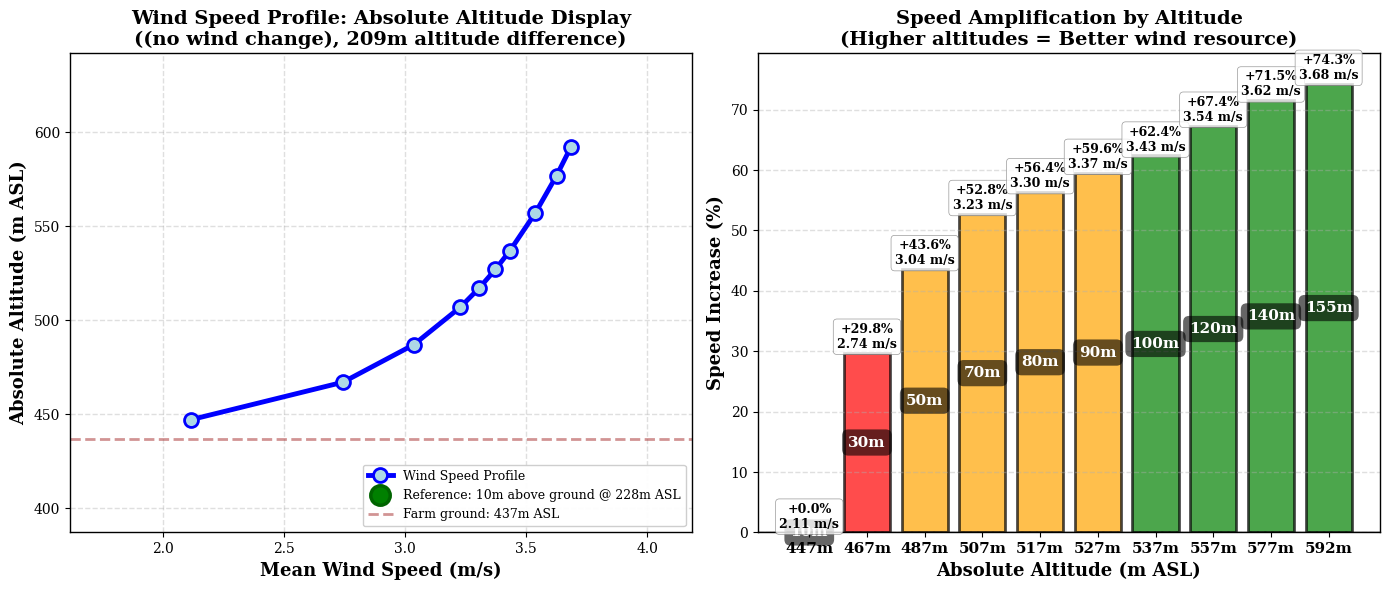


Chart saved as 'wind_shear_analysis.png'

  Height above ground: 155m
  Absolute altitude (ASL): 592m
  
  Wind speed at reference (228m ASL, 10m above ground): 2.113 m/s
  Wind speed at farm (437m ASL, 155m above ground): 3.683 m/s
  Change: +74.3%

Power Calculations:
  Baseline single turbine AEP: 4,717 MWh/year
  
  Corrections:
  Wind speed effect (v³): +429.5%
  Air density effect: -2.47%
  Combined effect: +416.5%
  
  single turbine AEP: 24,362 MWh/year
  farm AEP (13 turbines): 316,704 MWh/year

  This assumes (no wind change)

     

  Reference measurement: 10m height @ 228m altitude
  turbine hub: 155m height @ 592m altitude
  Altitude gain from reference to hub: 364m
    (145m height increase + 209m site altitude increase)



In [30]:
import numpy as np
import matplotlib.pyplot as plt




reference_height = 10  
z0 = 0.25 





reference_altitude = 228  # m ASL 
farm_altitude = 437  # m ASL
altitude_difference = farm_altitude - reference_altitude

# Air density calculation
T_lapse_rate = 0.0065  # K/m
T_sea_level = 288.15  # K
g = 9.81  # m/s²
R_specific = 287  # J/(kg·K)
rho_sea_level = 1.225  # kg/m³

# Density at reference altitude
T_ref = T_sea_level - T_lapse_rate * reference_altitude
rho_ref = rho_sea_level * (T_ref / T_sea_level) ** (g / (R_specific * T_lapse_rate))

# Density at farm altitude
T_farm = T_sea_level - T_lapse_rate * farm_altitude
rho_farm = rho_sea_level * (T_farm / T_sea_level) ** (g / (R_specific * T_lapse_rate))

# Air density correction factor
rho_correction = rho_farm / rho_ref

# Mean wind speed at reference
v_ref = df['wind_mean_speed_ms'].mean()

print(f"   Reference height above ground: {reference_height}m")
print(f"   Reference altitude (ASL): {reference_altitude}m")
print(f"   Farm altitude (ASL): {farm_altitude}m")
print(f"   Altitude difference: {altitude_difference}m")
print(f"   Mean wind speed: {v_ref:.3f} m/s")
print(f"   Surface roughness: z0 = {z0}m")

print(f"\n Air Density Effects:")
print(f"   Temperature at reference: {T_ref:.2f} K ({T_ref-273.15:.1f}°C)")
print(f"   Air density at reference: {rho_ref:.4f} kg/m³")
print(f"   Temperature at farm: {T_farm:.2f} K ({T_farm-273.15:.1f}°C)")
print(f"   Air density at farm: {rho_farm:.4f} kg/m³")
print(f"   Air density correction: {rho_correction:.6f}")
print(f"   Power loss from density: {(rho_correction-1)*100:.2f}%")



# Wind shear calculation function


def wind_speed_at_height(v_ref, z_ref, z, z0):
    """Logarithmic wind profile"""
    v_z = v_ref * np.log(z / z0) / np.log(z_ref / z0)
    return v_z


# WIND SPEED ADJUSTMENT OPTIONS





wind_speed_factor = 1.0  
scenario_name = "(no wind change)"




#v_ref for altitude
v_ref_at_farm = v_ref * wind_speed_factor

print(f"\n Wind Speed Scenario: {scenario_name}")
print(f"   Wind speed factor: {wind_speed_factor:.6f}")
print(f"   v_ref at farm altitude: {v_ref_at_farm:.3f} m/s (vs {v_ref:.3f} m/s at reference)")


# Calculate wind speeds at different hub heights


# Heights above ground (at farm location)
hub_heights_above_ground = np.array([10, 30, 50, 70, 80, 90, 100, 120, 140, 155])

# Convert to absolute altitudes (ASL)
hub_altitudes_asl = farm_altitude + hub_heights_above_ground

# Calculate wind speeds using ADJUSTED v_ref
wind_speeds = wind_speed_at_height(v_ref_at_farm, reference_height, hub_heights_above_ground, z0)


# Print results table



print(f"\n{'Height Above Ground':<25} {'Absolute Altitude (ASL)':<25} {'Wind Speed (m/s)':<20} {'Increase from Ref':<25}")
print("-"*95)

for h, alt, v in zip(hub_heights_above_ground, hub_altitudes_asl, wind_speeds):
    if h == reference_height:
        print(f"{h}m{'':<21} {alt}m{'':<20} {v:<20.3f} {'(reference)':<25}")
    else:
        increase_pct = ((v / v_ref_at_farm) - 1) * 100
        print(f"{h}m{'':<21} {alt}m{'':<20} {v:<20.3f} {'+' + f'{increase_pct:.1f}%':<25}")


# Create visualization


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


ax1 = axes[0]


ax1.plot(wind_speeds, hub_altitudes_asl, 'b-', linewidth=3.5, label='Wind Speed Profile', 
         marker='o', markersize=10, markerfacecolor='lightblue', markeredgewidth=2)

ax1.plot([v_ref_at_farm], [reference_altitude], 'go', markersize=14, 
         label=f'Reference: {reference_height}m above ground @ {reference_altitude}m ASL', 
         markeredgecolor='darkgreen', markeredgewidth=2.5, zorder=5)

ax1.axhline(y=farm_altitude, color='brown', linestyle='--', linewidth=2, 
           alpha=0.5, label=f'Farm ground: {farm_altitude}m ASL')

ax1.set_xlabel('Mean Wind Speed (m/s)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Absolute Altitude (m ASL)', fontsize=13, fontweight='bold')
ax1.set_title(f'Wind Speed Profile: Absolute Altitude Display\n({scenario_name}, {altitude_difference}m altitude difference)', 
             fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.4, linestyle='--', linewidth=1)
ax1.legend(fontsize=9, loc='lower right', framealpha=0.95)

x_min = wind_speeds.min() - 0.5
x_max = wind_speeds.max() + 0.5
ax1.set_xlim([x_min, x_max])
ax1.set_ylim([farm_altitude - 50, max(hub_altitudes_asl) + 50])

#  Percentage Speed Increase 
ax2 = axes[1]

speed_increase_pct = ((wind_speeds / v_ref_at_farm) - 1) * 100

colors = []
for h in hub_heights_above_ground:
    if h < 50:
        colors.append('red')
    elif h < 100:
        colors.append('orange')
    else:
        colors.append('green')


bar_positions = np.arange(len(hub_heights_above_ground))
bars = ax2.bar(bar_positions, speed_increase_pct, color=colors, alpha=0.7, 
              edgecolor='black', linewidth=2, width=0.8)


ax2.set_xticks(bar_positions)
ax2.set_xticklabels([f'{int(alt)}m' for alt in hub_altitudes_asl], fontsize=11, fontweight='bold')
ax2.set_xlabel('Absolute Altitude (m ASL)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Speed Increase (%)', fontsize=13, fontweight='bold')
ax2.set_title('Speed Amplification by Altitude\n(Higher altitudes = Better wind resource)', 
             fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.4, axis='y', linestyle='--', linewidth=1)


for idx, (bar, h, pct_val, v_speed) in enumerate(zip(bars, hub_heights_above_ground, speed_increase_pct, wind_speeds)):
    height = bar.get_height()
    
    ax2.text(idx, height * 0.5,
            f'{int(h)}m',
            ha='center', va='center', fontsize=11, fontweight='bold', color='white',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='black', alpha=0.6, edgecolor='none'))
    
    ax2.text(idx, height + 0.3,
            f'+{pct_val:.1f}%\n{v_speed:.2f} m/s',
            ha='center', va='bottom', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, 
                     edgecolor='gray', linewidth=0.5))

ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_ylim([0, max(speed_increase_pct) + 5])

plt.tight_layout()
plt.savefig('wind_shear_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nChart saved as 'wind_shear_analysis.png'")


idx_155 = np.argmin(np.abs(hub_heights_above_ground - 155))
v_155 = wind_speeds[idx_155]
h_155_above_ground = hub_heights_above_ground[idx_155]
alt_155_asl = hub_altitudes_asl[idx_155]
increase_155 = ((v_155 / v_ref_at_farm) - 1) * 100


baseline_aep = 4717

wind_power_factor = (v_155 / v_ref) ** 3  # Including altitude wind change
density_factor = rho_correction

total_power_factor = wind_power_factor * density_factor

corrected_aep = baseline_aep * total_power_factor

print(f"""
  Height above ground: {h_155_above_ground}m
  Absolute altitude (ASL): {alt_155_asl}m
  
  Wind speed at reference ({reference_altitude}m ASL, {reference_height}m above ground): {v_ref:.3f} m/s
  Wind speed at farm ({farm_altitude}m ASL, {h_155_above_ground}m above ground): {v_155:.3f} m/s
  Change: +{increase_155:.1f}%

Power Calculations:
  Baseline single turbine AEP: {baseline_aep:,.0f} MWh/year
  
  Corrections:
  Wind speed effect (v³): {(wind_power_factor - 1)*100:+.1f}%
  Air density effect: {(density_factor - 1)*100:+.2f}%
  Combined effect: {(total_power_factor - 1)*100:+.1f}%
  
  single turbine AEP: {corrected_aep:,.0f} MWh/year
  farm AEP (13 turbines): {corrected_aep * 13:,.0f} MWh/year

  This assumes {scenario_name}

     

  Reference measurement: {reference_height}m height @ {reference_altitude}m altitude
  turbine hub: {h_155_above_ground}m height @ {alt_155_asl}m altitude
  Altitude gain from reference to hub: {alt_155_asl - reference_altitude}m
    ({h_155_above_ground - reference_height}m height increase + {farm_altitude - reference_altitude}m site altitude increase)
""")




SITE CONFIGURATION:
  Reference: 10m height, 228m altitude, density = 1.1922 kg/m³
  Farm: 437m altitude, density = 1.1628 kg/m³
  Density correction factor: 0.975330
  Wind at 10m: 2.1132 m/s
  Weibull parameters: k=1.4306, A=2.3475
 C:/Users/faisa/Downloads/turbine_power_curves_merged.xlsx
Loaded 6 turbines:
  • Gamesa G128-5.0MW (5.0 MW, 140.0m hub)
  • Siemens SWT-3.6-120 Onshore (3.6 MW, 90.0m hub)
  • Vestas V136-3.45 (3.45 MW, 149.0m hub)
  • Senvion MM100 (2.0 MW, 100.0m hub)
  • AN Bonus 1000 (1.0 MW, 70.0m hub)
  • Gamesa G90 (2.0 MW, 90.0m hub)

RESULTS (Ranked by AEP):
1. Gamesa G128-5.0MW                   →    4,305 MWh/yr | CF:   9.83%
2. Vestas V136-3.45                    →    3,936 MWh/yr | CF:  13.02%
3. Siemens SWT-3.6-120 Onshore         →    2,802 MWh/yr | CF:   8.89%
4. Senvion MM100                       →    1,940 MWh/yr | CF:  11.07%
5. Gamesa G90                          →    1,556 MWh/yr | CF:   8.88%
6. AN Bonus 1000                       →      514 MWh/yr

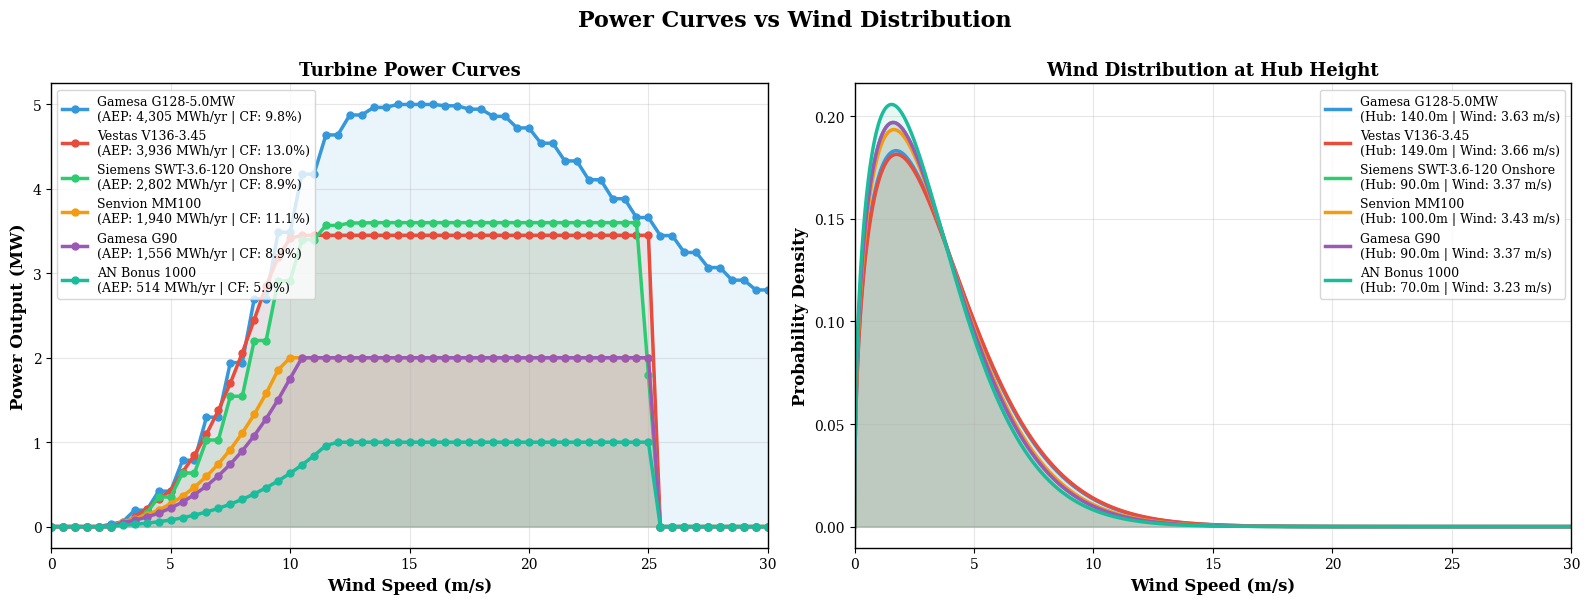

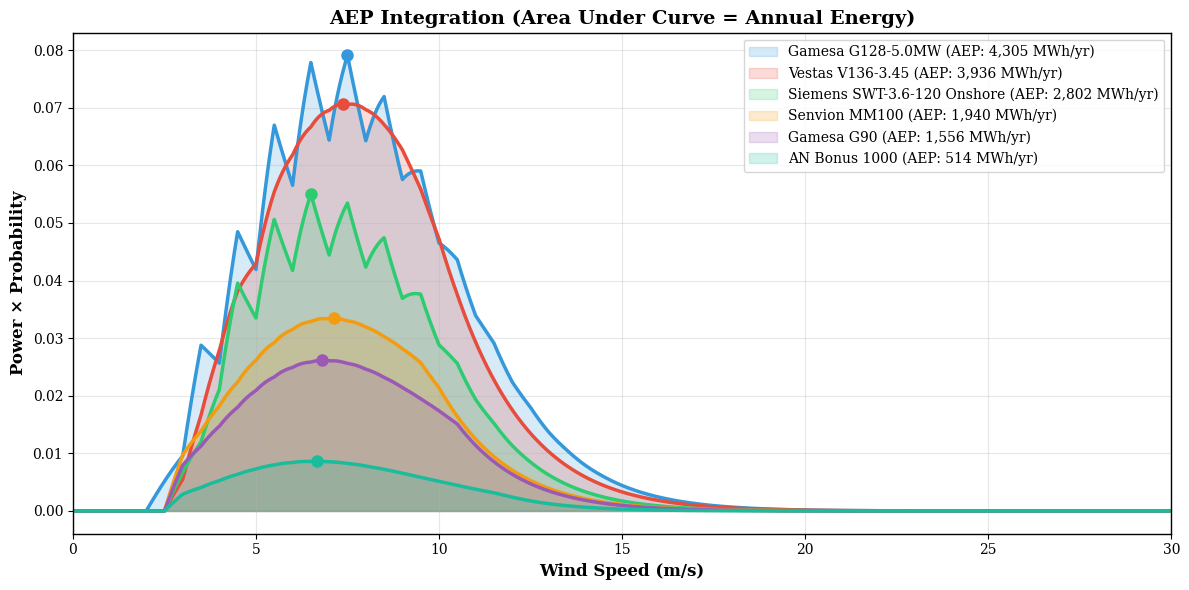

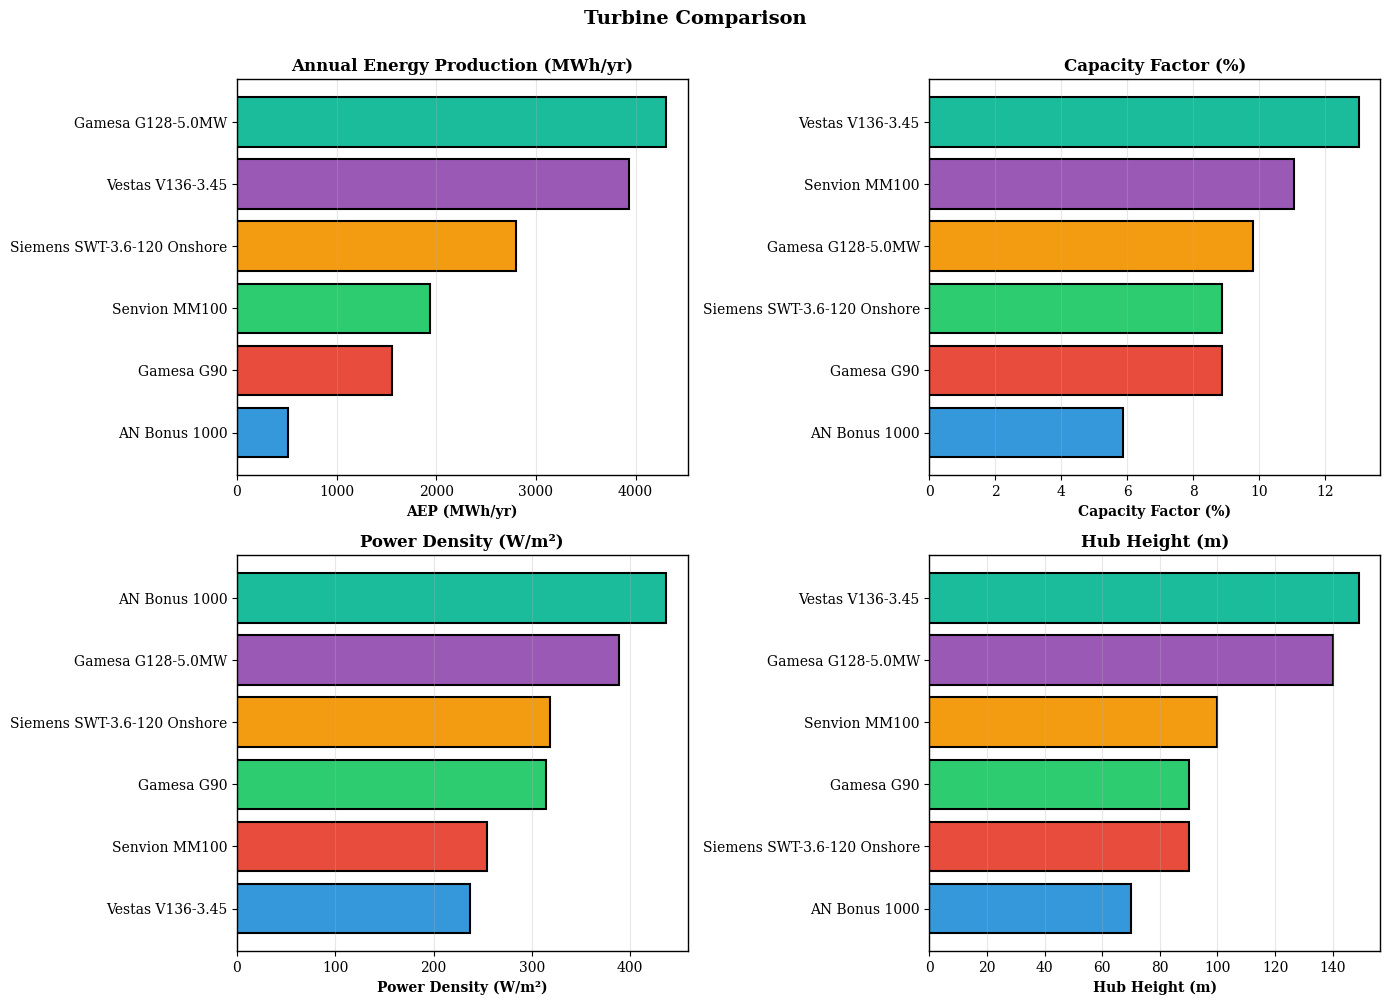

\Results exported to: turbine_analysis_results.csv


In [31]:

from scipy.stats import weibull_min
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Jupyter compatibility
try:
    get_ipython()
    from IPython.display import display
    is_jupyter = True
except NameError:
    is_jupyter = False

if is_jupyter:
    get_ipython().run_line_magic('matplotlib', 'inline')


# Reference conditions
reference_height = 10  # meters
reference_altitude = 228  # meters above sea level
surface_roughness = 0.25  # z0 in meters
farm_altitude = 437  # meters above sea level

# Wind characteristics at reference height
measured_wind_speed = 2.1132  # m/s
weibull_shape = 1.4306  # k parameter
weibull_scale = 2.3475  # A parameter

# Atmospheric constants
temp_lapse_rate = 0.0065  # K/m
sea_level_temp = 288.15  # K
gravity = 9.81  # m/s²
gas_constant = 287  # J/(kg·K)
sea_level_density = 1.225  # kg/m³

# Calculate air density at reference and farm altitudes
temp_reference = sea_level_temp - temp_lapse_rate * reference_altitude
density_reference = sea_level_density * (temp_reference / sea_level_temp) ** (gravity / (gas_constant * temp_lapse_rate))

temp_farm = sea_level_temp - temp_lapse_rate * farm_altitude
density_farm = sea_level_density * (temp_farm / sea_level_temp) ** (gravity / (gas_constant * temp_lapse_rate))

density_correction_factor = density_farm / density_reference

print("\nSITE CONFIGURATION:")
print(f"  Reference: {reference_height}m height, {reference_altitude}m altitude, density = {density_reference:.4f} kg/m³")
print(f"  Farm: {farm_altitude}m altitude, density = {density_farm:.4f} kg/m³")
print(f"  Density correction factor: {density_correction_factor:.6f}")
print(f"  Wind at {reference_height}m: {measured_wind_speed:.4f} m/s")
print(f"  Weibull parameters: k={weibull_shape:.4f}, A={weibull_scale:.4f}")


excel_file = "C:/Users/faisa/Downloads/turbine_power_curves_merged.xlsx"


try:
    df = pd.read_excel(excel_file, sheet_name='All Turbines Comparison')
    print(f" {excel_file}")
except FileNotFoundError:
    print(f"Could not find {excel_file}")
    raise


specs = df.iloc[2:8, :6].reset_index(drop=True)
specs.columns = ['Turbine', 'Rated_Power_MW', 'Rotor_Diameter_m', 'Hub_Height_m', 'Cut_in_ms', 'Rated_Speed_ms']


specs['Turbine'] = specs['Turbine'].astype(str)
specs = specs[specs['Turbine'] != 'nan'].reset_index(drop=True)


power_curves = df.iloc[11:, :7].reset_index(drop=True)
wind_speeds = pd.to_numeric(power_curves.iloc[:, 0], errors='coerce').dropna().values

turbines = []
for idx, row in specs.iterrows():
    turbine = {
        'name': str(row['Turbine']),
        'rated_power': float(row['Rated_Power_MW']),
        'rotor_diameter': float(row['Rotor_Diameter_m']),
        'hub_height': float(row['Hub_Height_m']),
        'cut_in_speed': float(row['Cut_in_ms']),
        'rated_speed': float(row['Rated_Speed_ms'])
    }
    
    
    power_col = power_curves.iloc[:, idx + 1]
    power_data = pd.to_numeric(power_col, errors='coerce').dropna()
    
    # Match wind speeds with power data
    valid_indices = power_data.index
    turbine['power_curve_speed'] = wind_speeds[:len(valid_indices)]
    turbine['power_curve_power'] = (power_data.values / 1000.0)[:len(valid_indices)]  # Convert kW to MW
    
    turbines.append(turbine)

print(f"Loaded {len(turbines)} turbines:")
for t in turbines:
    print(f"  • {t['name']} ({t['rated_power']} MW, {t['hub_height']}m hub)")


# CALCULATE AEP FOR EACH TURBINE




results = []

for turbine in turbines:
    # Scale wind speed to hub height using logarithmic wind profile
    hub_height = turbine['hub_height']
    wind_at_hub = measured_wind_speed * (np.log(hub_height / surface_roughness) / 
                                          np.log(reference_height / surface_roughness))
    
    # Scale Weibull distribution to hub height
    weibull_scale_hub = weibull_scale * (wind_at_hub / measured_wind_speed)
    
    # Create interpolation function for power curve
    power_interpolator = interp1d(turbine['power_curve_speed'], 
                                   turbine['power_curve_power'],
                                   kind='linear', bounds_error=False, fill_value=0)
    
    # Calculate AEP using numerical integration
    wind_range = np.linspace(0, 30, 3001)
    power_at_wind = power_interpolator(wind_range)
    probability_density = weibull_min.pdf(wind_range, weibull_shape, scale=weibull_scale_hub)
    energy_integrand = power_at_wind * probability_density
    
    # Annual energy
    aep_raw = trapezoid(energy_integrand, wind_range) * 8760
    aep_corrected = aep_raw * density_correction_factor
    
    # Capacity factor
    capacity_factor = (aep_corrected / (turbine['rated_power'] * 8760)) * 100
    
    results.append({
        'turbine': turbine['name'],
        'rated_power_mw': turbine['rated_power'],
        'hub_height_m': hub_height,
        'rotor_diameter_m': turbine['rotor_diameter'],
        'wind_at_hub_ms': wind_at_hub,
        'weibull_scale_hub': weibull_scale_hub,
        'aep_mwh': aep_corrected,
        'capacity_factor_pct': capacity_factor,
        'avg_power_mw': aep_corrected / 8760,
        'power_density_wm2': (turbine['rated_power'] * 1e6) / (np.pi * (turbine['rotor_diameter'] / 2) ** 2),
        'wind_range': wind_range,
        'power_at_wind': power_at_wind,
        'probability_density': probability_density,
        'energy_integrand': energy_integrand,
        'power_curve_speed': turbine['power_curve_speed'],
        'power_curve_power': turbine['power_curve_power']
    })

results_df = pd.DataFrame(results)
results_sorted = results_df.sort_values('aep_mwh', ascending=False).reset_index(drop=True)



print("\nRESULTS (Ranked by AEP):")

for idx, row in results_sorted.iterrows():
    print(f"{idx+1}. {row['turbine']:35s} → {row['aep_mwh']:>8,.0f} MWh/yr | CF: {row['capacity_factor_pct']:>6.2f}%")


colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for idx, row in results_sorted.iterrows():
    color = colors[idx % len(colors)]
    label = f"{row['turbine']}\n(AEP: {row['aep_mwh']:,.0f} MWh/yr | CF: {row['capacity_factor_pct']:.1f}%)"
    
    # Power curves
    ax1.plot(row['power_curve_speed'], row['power_curve_power'], 'o-', 
             linewidth=2.5, markersize=5, label=label, color=color)
    ax1.fill_between(row['power_curve_speed'], row['power_curve_power'], alpha=0.1, color=color)
    
    # Weibull distributions
    wind_label = f"{row['turbine']}\n(Hub: {row['hub_height_m']}m | Wind: {row['wind_at_hub_ms']:.2f} m/s)"
    ax2.plot(row['wind_range'], row['probability_density'], linewidth=2.5, label=wind_label, color=color)
    ax2.fill_between(row['wind_range'], row['probability_density'], alpha=0.1, color=color)

ax1.set_xlabel('Wind Speed (m/s)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Power Output (MW)', fontweight='bold', fontsize=12)
ax1.set_title('Turbine Power Curves', fontweight='bold', fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9, loc='upper left')
ax1.set_xlim(0, 30)

ax2.set_xlabel('Wind Speed (m/s)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Probability Density', fontweight='bold', fontsize=12)
ax2.set_title('Wind Distribution at Hub Height', fontweight='bold', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=9, loc='upper right')
ax2.set_xlim(0, 30)

fig.suptitle('Power Curves vs Wind Distribution', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Plot 2: AEP Integration
fig, ax = plt.subplots(figsize=(12, 6))

for idx, row in results_sorted.iterrows():
    color = colors[idx % len(colors)]
    label = f"{row['turbine']} (AEP: {row['aep_mwh']:,.0f} MWh/yr)"
    
    ax.fill_between(row['wind_range'], row['energy_integrand'], alpha=0.2, color=color, label=label)
    ax.plot(row['wind_range'], row['energy_integrand'], color=color, linewidth=2.5)
    
    # Mark peak
    peak_idx = np.argmax(row['energy_integrand'])
    ax.plot(row['wind_range'][peak_idx], row['energy_integrand'][peak_idx], 'o', markersize=8, color=color)

ax.set_xlabel('Wind Speed (m/s)', fontweight='bold', fontsize=12)
ax.set_ylabel('Power × Probability', fontweight='bold', fontsize=12)
ax.set_title('AEP Integration (Area Under Curve = Annual Energy)', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='upper right')
ax.set_xlim(0, 30)
plt.tight_layout()
plt.show()

# Plot 3: Comparison Metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = [
    ('aep_mwh', 'Annual Energy Production (MWh/yr)', 'AEP (MWh/yr)'),
    ('capacity_factor_pct', 'Capacity Factor (%)', 'Capacity Factor (%)'),
    ('power_density_wm2', 'Power Density (W/m²)', 'Power Density (W/m²)'),
    ('hub_height_m', 'Hub Height (m)', 'Hub Height (m)')
]

for idx, (metric, title, xlabel) in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    sorted_data = results_sorted.sort_values(metric, ascending=True)
    
    bars = ax.barh(sorted_data['turbine'], sorted_data[metric], 
                   color=[colors[i % len(colors)] for i in range(len(sorted_data))],
                   edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel(xlabel, fontweight='bold')
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('Turbine Comparison', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()



output_df = results_sorted[['turbine', 'rated_power_mw', 'hub_height_m', 
                             'power_density_wm2', 'aep_mwh', 'capacity_factor_pct']].copy()
output_df.columns = ['Turbine', 'Rated Power (MW)', 'Hub Height (m)', 
                     'Power Density (W/m²)', 'AEP (MWh/year)', 'Capacity Factor (%)']

output_file = 'turbine_analysis_results.csv'
output_df.to_csv(output_file, index=False)

print(f"\Results exported to: {output_file}")


  Reference height: 10 m  |  Reference altitude: 228 m
  Farm altitude:    437 m
  Air density: ρ_ref=1.1922 kg/m³   ρ_farm=1.1628 kg/m³   factor=0.97533
  Wind at 10 m: mean=2.1132 m/s  Weibull k=1.4306, A=2.3475
6 turbines:
 Gamesa G128-5.0MW (5.0 MW, D=128.0 m, hub=140.0 m)
 Siemens SWT-3.6-120 Onshore (3.6 MW, D=120.0 m, hub=90.0 m)
 Vestas V136-3.45 (3.45 MW, D=136.0 m, hub=149.0 m)
 Senvion MM100 (2.0 MW, D=100.0 m, hub=100.0 m)
 AN Bonus 1000 (1.0 MW, D=54.0 m, hub=70.0 m)
 Gamesa G90 (2.0 MW, D=90.0 m, hub=90.0 m)
AEP BY TURBINE AND HUB HEIGHT
------------------------------------------------------------------------------------------
AN Bonus 1000                  : 70.0 m → 514 MWh/yr (CF 5.9%)
Gamesa G128-5.0MW              : 90.0 m → 3,570 MWh/yr (CF 8.2%) | 110.0 m → 3,898 MWh/yr (CF 8.9%) | 127.5 m → 4,146 MWh/yr (CF 9.5%)
Gamesa G90                     : 67.0 m → 1,354 MWh/yr (CF 7.7%) | 78.0 m → 1,457 MWh/yr (CF 8.3%) | 90.0 m → 1,556 MWh/yr (CF 8.9%) | 100.0 m → 1,631 MW

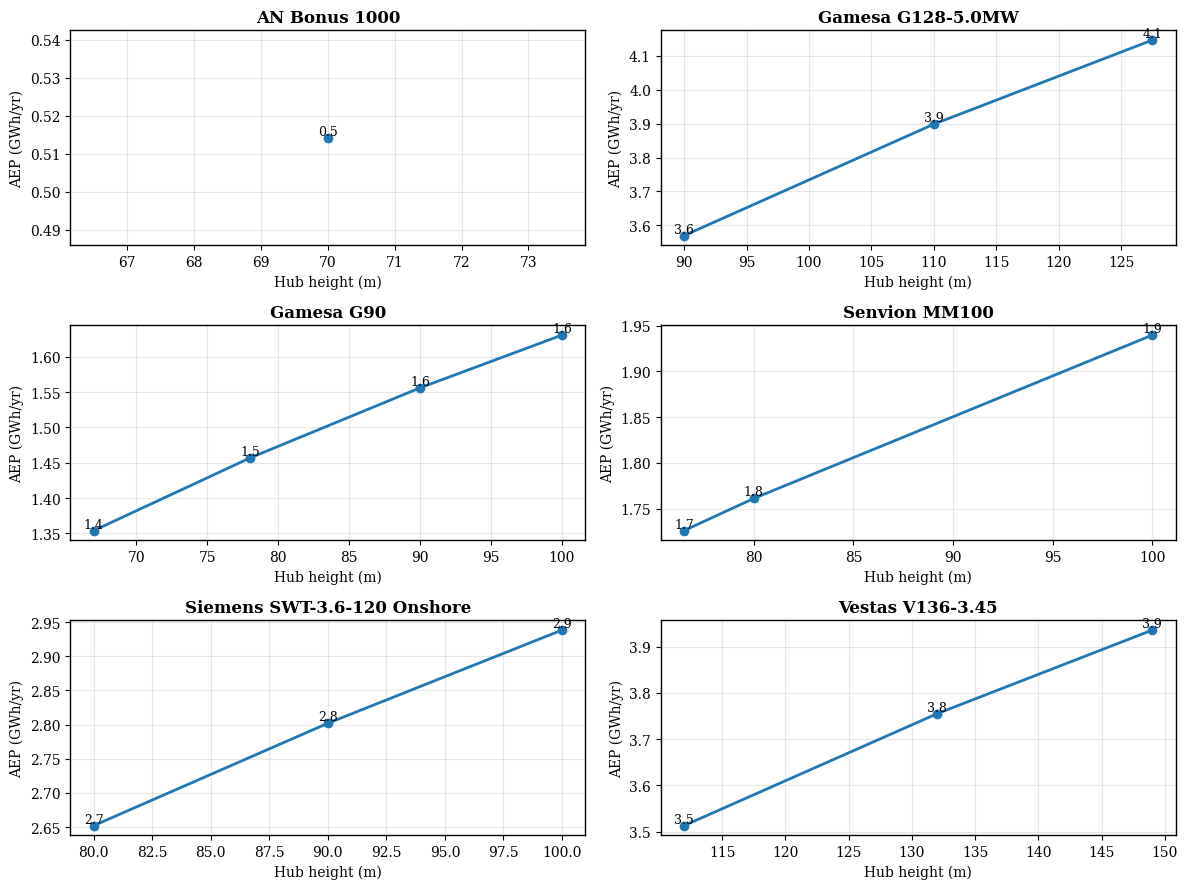

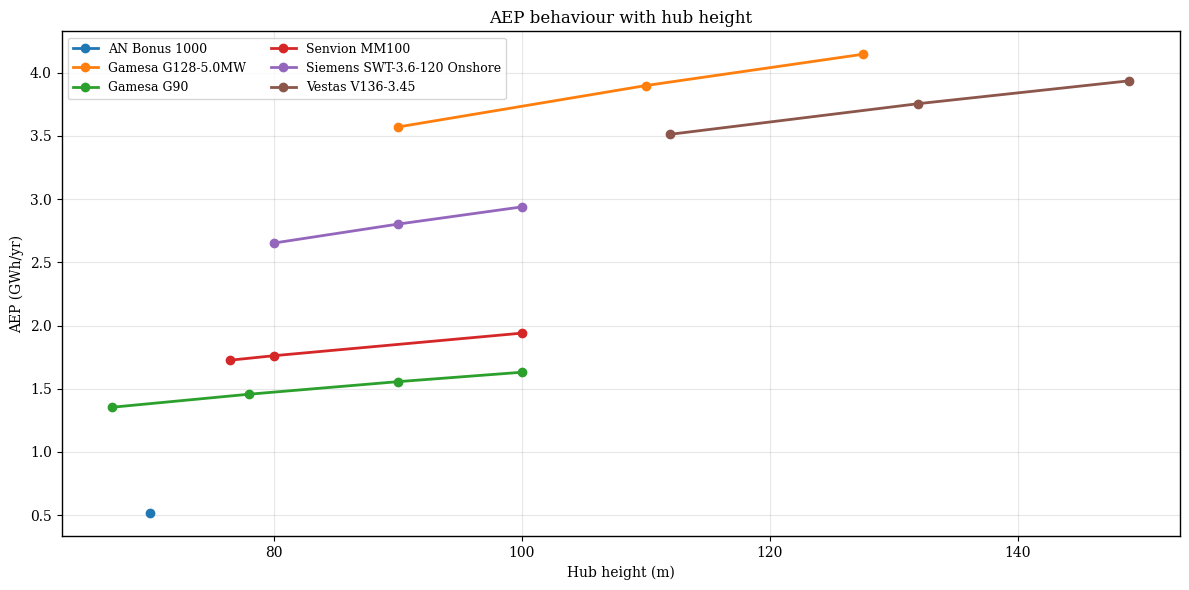

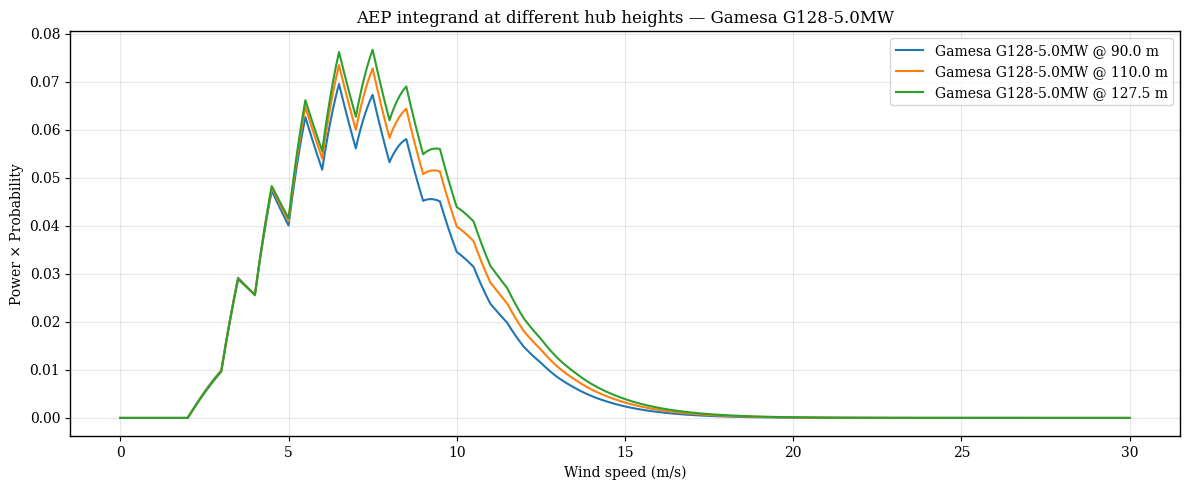

In [33]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import weibull_min
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')


# Reference conditions
reference_height   = 10.0    
reference_altitude = 228.0    
surface_roughness  = 0.25     
farm_altitude      = 437.0    


measured_wind_speed = 2.1132  
weibull_shape       = 1.4306 
weibull_scale       = 2.3475  


temp_lapse_rate  = 0.0065  
sea_level_temp   = 288.15  
gravity          = 9.81  
gas_constant     = 287.0    
sea_level_density= 1.225   


T_ref = sea_level_temp - temp_lapse_rate * reference_altitude
rho_ref = sea_level_density * (T_ref / sea_level_temp) ** (gravity / (gas_constant * temp_lapse_rate))

T_farm = sea_level_temp - temp_lapse_rate * farm_altitude
rho_farm = sea_level_density * (T_farm / sea_level_temp) ** (gravity / (gas_constant * temp_lapse_rate))

density_correction = rho_farm / rho_ref


print(f"  Reference height: {reference_height:.0f} m  |  Reference altitude: {reference_altitude:.0f} m")
print(f"  Farm altitude:    {farm_altitude:.0f} m")
print(f"  Air density: ρ_ref={rho_ref:.4f} kg/m³   ρ_farm={rho_farm:.4f} kg/m³   factor={density_correction:.5f}")
print(f"  Wind at {reference_height:.0f} m: mean={measured_wind_speed:.4f} m/s  Weibull k={weibull_shape:.4f}, A={weibull_scale:.4f}")



excel_file = Path("C:/Users/faisa/Downloads/turbine_power_curves_merged.xlsx") 

try:
    df = pd.read_excel(excel_file, sheet_name='All Turbines Comparison')
except FileNotFoundError:
    raise FileNotFoundError(f"Could not find {excel_file.resolve()}")


specs = df.iloc[2:8, :6].reset_index(drop=True)
specs.columns = ['Turbine', 'Rated_Power_MW', 'Rotor_Diameter_m', 'Hub_Height_m', 'Cut_in_ms', 'Rated_Speed_ms']
specs = specs[specs['Turbine'].astype(str) != 'nan'].reset_index(drop=True)

# Power curves block
power_curves = df.iloc[11:, :7].reset_index(drop=True)
wind_speeds = pd.to_numeric(power_curves.iloc[:, 0], errors='coerce').dropna().values

# Build turbine objects
turbines = []
for idx, row in specs.iterrows():
    name = str(row['Turbine']).strip()
    rated_power = float(row['Rated_Power_MW'])
    rotor_diam  = float(row['Rotor_Diameter_m'])
    hub_height  = float(row['Hub_Height_m'])
    cut_in      = float(row['Cut_in_ms'])
    v_rated     = float(row['Rated_Speed_ms'])

    p_col = power_curves.iloc[:, idx + 1]
    p_kw  = pd.to_numeric(p_col, errors='coerce').dropna().values
    v_pc  = wind_speeds[:len(p_kw)]
    p_mw  = (p_kw / 1000.0)[:len(v_pc)]

    turbines.append({
        "name": name,
        "rated_power": rated_power,
        "rotor_diameter": rotor_diam,
        "hub_height_catalogue": hub_height,
        "cut_in_speed": cut_in,
        "rated_speed": v_rated,
        "pc_speed": v_pc,
        "pc_power_mw": p_mw
    })

print(f"{len(turbines)} turbines:")
for t in turbines:
    print(f" {t['name']} ({t['rated_power']} MW, D={t['rotor_diameter']} m, hub={t['hub_height_catalogue']} m)")


HUB_HEIGHT_VARIANTS = {
    "gamesa g128":        [90, 110, 127.5],
    "vestas v136":        [112, 132, 149],
    "siemens swt 3.6":    [80, 90, 100],
    "senvion mm100":      [76.5, 80, 100],
    "an bonus 1000/54":   [50, 60, 70],
    "gamesa g90":         [67, 78, 90, 100],
}

ALIASES = {
    "gamesia": "gamesa",
    "seimens": "siemens",
    "swt3.6": "swt 3.6",
    "swt-3.6": "swt 3.6",
}

def normalise_name(s: str) -> str:
    s = s.strip().lower()
    for wrong, right in ALIASES.items():
        s = s.replace(wrong, right)
    s = re.sub(r"[\s\-_/]+", " ", s)
    return s

def pick_height_list(turbine_name: str, default_hub: float) -> list:
    n = normalise_name(turbine_name)

    if n in HUB_HEIGHT_VARIANTS:
        return HUB_HEIGHT_VARIANTS[n]

    for key in HUB_HEIGHT_VARIANTS:
        if key in n:
            return HUB_HEIGHT_VARIANTS[key]

    return [float(default_hub)]


def wind_at_height_log(v_ref, z_ref, z, z0):
    """Log-law shear: v(z) = v_ref * ln(z/z0) / ln(z_ref/z0)."""
    z = np.asarray(z, dtype=float)
    return v_ref * np.log(z / z0) / np.log(z_ref / z0)

def aep_for_height(turb, hub_h):
    """
    AEP integration for a single turbine at a single hub height.
    Returns dict with intermediates for plotting.
    """
    # shear scaling of mean and Weibull A
    v_hub = wind_at_height_log(measured_wind_speed, reference_height, hub_h, surface_roughness)
    A_hub = weibull_scale * (v_hub / measured_wind_speed)

    # power curve interpolator
    fP = interp1d(turb["pc_speed"], turb["pc_power_mw"],
                  kind="linear", bounds_error=False, fill_value=0.0)

    # integrate power * pdf over speed, then times hours and density factor
    ws = np.linspace(0, 30, 3001)
    P  = fP(ws)                              # MW
    pdf = weibull_min.pdf(ws, weibull_shape, scale=A_hub)
    integrand = P * pdf
    aep_raw = trapezoid(integrand, ws) * 8760.0  # MWh per year at reference density
    aep_corr = aep_raw * density_correction      # corrected to farm density

    cf = aep_corr / (turb["rated_power"] * 8760.0) * 100.0

    return {
        "turbine": turb["name"],
        "hub_height_m": float(hub_h),
        "aep_mwh": float(aep_corr),
        "capacity_factor_pct": float(cf),
        "avg_power_mw": float(aep_corr / 8760.0),
        "wind_at_hub_ms": float(v_hub),
        "weibull_A_hub": float(A_hub),
        "wind_range": ws,
        "integrand": integrand,
        "pdf": pdf,
        "P_of_v": P,
    }

# compute for all requested hub heights
rows = []
for turb in turbines:
    heights = pick_height_list(turb["name"], turb["hub_height_catalogue"])
    for H in heights:
        rows.append(aep_for_height(turb, H))

results = pd.DataFrame(rows)

# attach static turbine data for reporting
turbine_meta = pd.DataFrame([{
    "turbine": t["name"],
    "rated_power_mw": t["rated_power"],
    "rotor_diameter_m": t["rotor_diameter"],
} for t in turbines])

results = results.merge(turbine_meta, on="turbine", how="left")

# sorted views
results_sorted = results.sort_values(["turbine", "hub_height_m"]).reset_index(drop=True)
ranked_by_aep   = results.sort_values("aep_mwh", ascending=False).reset_index(drop=True)

print("AEP BY TURBINE AND HUB HEIGHT")
print("-"*90)
for name, grp in results_sorted.groupby("turbine"):
    line = " | ".join([f"{h:.1f} m → {aep:,.0f} MWh/yr (CF {cf:.1f}%)"
                       for h, aep, cf in zip(grp["hub_height_m"], grp["aep_mwh"], grp["capacity_factor_pct"])])
    print(f"{name:30s} : {line}")

# top 10 single configurations by AEP
print("-"*90)
topn = min(10, len(ranked_by_aep))
for i in range(topn):
    r = ranked_by_aep.iloc[i]
    print(f"{i+1:>2}. {r['turbine']:30s} @ {r['hub_height_m']:>6.1f} m  →  {r['aep_mwh']:>10,.0f} MWh/yr  |  CF {r['capacity_factor_pct']:>5.1f}%")


# 1) AEP vs hub height per turbine

n_turb = results['turbine'].nunique()
ncols = 2
nrows = int(np.ceil(n_turb / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, max(4, 3*nrows)), squeeze=False)

for ax, (name, grp) in zip(axes.ravel(), results_sorted.groupby("turbine")):
    ax.plot(grp["hub_height_m"], grp["aep_mwh"]/1000.0, marker="o", linewidth=2)
    for x, y in zip(grp["hub_height_m"], grp["aep_mwh"]/1000.0):
        ax.text(x, y, f"{y:.1f}", va="bottom", ha="center", fontsize=9)
    ax.set_title(name, fontweight="bold")
    ax.set_xlabel("Hub height (m)")
    ax.set_ylabel("AEP (GWh/yr)")
    ax.grid(True, alpha=0.3)

for j in range(n_turb, nrows*ncols):
    fig.delaxes(axes.ravel()[j])

plt.tight_layout()
plt.show()

# 2) Combined comparison at each turbine’s heights
fig, ax = plt.subplots(figsize=(12, 6))
for name, grp in results_sorted.groupby("turbine"):
    ax.plot(grp["hub_height_m"], grp["aep_mwh"]/1000.0, marker="o", linewidth=2, label=name)
ax.set_xlabel("Hub height (m)")
ax.set_ylabel("AEP (GWh/yr)")
ax.set_title("AEP behaviour with hub height")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


example_name = None
for key in HUB_HEIGHT_VARIANTS:
    # find the first results group that matches this key fuzzily
    for nm in results['turbine'].unique():
        if key in normalise_name(nm):
            example_name = nm
            break
    if example_name:
        break

if example_name:
    grp = results_sorted[results_sorted["turbine"] == example_name]
    fig, ax = plt.subplots(figsize=(12, 5))
    for _, r in grp.iterrows():
        ax.plot(r["wind_range"], r["integrand"], label=f"{example_name} @ {r['hub_height_m']:.1f} m")
    ax.set_xlabel("Wind speed (m/s)")
    ax.set_ylabel("Power × Probability")
    ax.set_title(f"AEP integrand at different hub heights — {example_name}")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


out = results_sorted[[
    "turbine", "hub_height_m", "aep_mwh", "capacity_factor_pct",
    "avg_power_mw", "wind_at_hub_ms", "weibull_A_hub",
    "rated_power_mw", "rotor_diameter_m"
]].copy()

out.rename(columns={
    "turbine": "Turbine",
    "hub_height_m": "Hub Height (m)",
    "aep_mwh": "AEP (MWh/year)",
    "capacity_factor_pct": "Capacity Factor (%)",
    "avg_power_mw": "Average Power (MW)",
    "wind_at_hub_ms": "Mean Wind @ Hub (m/s)",
    "weibull_A_hub": "Weibull A @ Hub (m/s)",
    "rated_power_mw": "Rated Power (MW)",
    "rotor_diameter_m": "Rotor Diameter (m)"
}, inplace=True)

csv_path = Path("turbine_aep_by_hub_height.csv")
out.to_csv(csv_path, index=False)



 Loaded: C:/Users/faisa/Downloads/turbine_power_curves_merged.xlsx
Selected turbine: Vestas V136-3.45
Rated power: 3.45 MW
Rotor diameter: 136.0 m
Hub height: 149.0 m
Cut-in speed: 3.0 m/s
Rated speed: 12.0 m/s
Power curve points: 61

Wind scaling to hub height:
  Reference wind (10 m): 2.1132 m/s
  Wind at hub (149 m): 3.6607 m/s
  Weibull k (ref): 1.4306
  Weibull A at hub: 4.0666

Wind direction configuration:
  Direction sectors: 36
  Probability type: Uniform
Thrust coefficient range: 0.000 to 0.539
SITE BOUNDARY SETUP
Boundary area: 5,000,000 m² (5.000 km²)
Boundary perimeter: 9000 m
Number of turbines: 12
Minimum spacing: 544 m (4D)
 Initial positions generated: 12 turbines


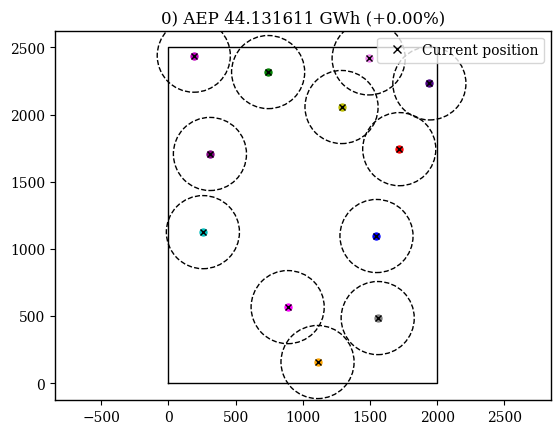

Optimization terminated successfully    (Exit mode 0)
            Current function value: -451.85116955620083
            Iterations: 59
            Function evaluations: 261
            Gradient evaluations: 59
Optimization Complete
-----------------------------------
Initial AEP: 44.13 GWh/year
Optimised AEP: 45.19 GWh/year
Improvement: 1.05 GWh/year (2.4%)

Number of turbines: 12
Per turbine AEP: 3.765 GWh/year
Capacity factor: 12.46%
Power density: 9037.02 W/m²


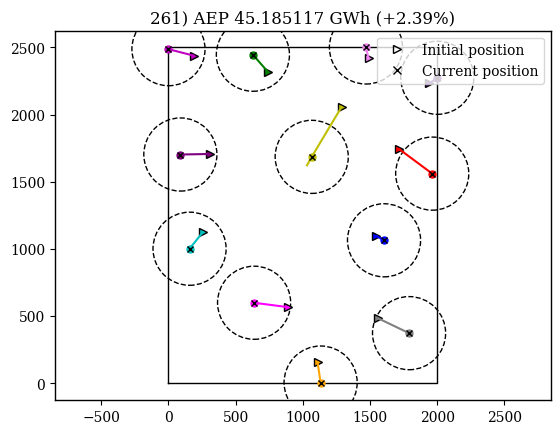

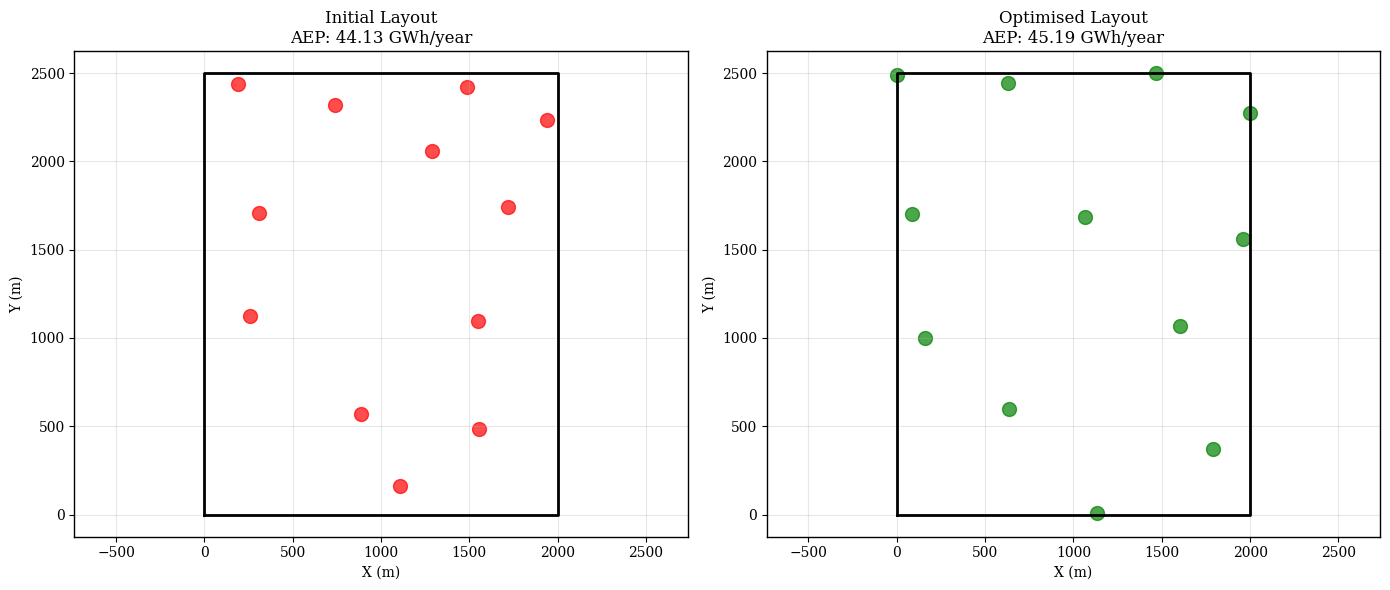

In [34]:


import xarray as xr
from scipy.optimize import fsolve
from scipy.stats import weibull_min
from shapely.geometry import Point, Polygon

# PyWake
from py_wake import BastankhahGaussian
from py_wake.utils.gradients import autograd
from py_wake.site import UniformWeibullSite
from py_wake.wind_turbines import WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

# TopFarm
from topfarm import TopFarmProblem
from topfarm.plotting import XYPlotComp
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint


reference_wind_speed = 2.1132     
weibull_shape_ref    = 1.4306    
weibull_scale_ref    = 2.3475   
reference_height     = 10.0    
surface_roughness    = 0.25      


n_sectors = 36
wd_bins = np.linspace(0, 360, n_sectors, endpoint=False) + 5.0  # sector midpoints


# 2) LOAD TURBINE FROM EXCEL AND POWER CURVE


try:
    excel_file = "C:/Users/faisa/Downloads/turbine_power_curves_merged.xlsx"
    df_turbines = pd.read_excel(excel_file, sheet_name="All Turbines Comparison")
    file_type = "merged"
    print(f" Loaded: {excel_file}")
except FileNotFoundError:
    print("Merged file not found, using original file...")
    excel_file = "turbine_power_curves_newoct28.xlsx"
    df_turbines = pd.read_excel(excel_file, sheet_name="All Turbines Comparison")
    file_type = "original"
    print(f" Loaded: {excel_file}")

# Select which turbine to use 
if file_type == "merged":
    # Rows 2:7 contain specs for 6 turbines in this sheet layout
    turbine_index = 2  # 0..5
    specs = df_turbines.iloc[2:8, :6].reset_index(drop=True)
    power_start_row = 11
else:
    turbine_index = 2  # 0..2
    specs = df_turbines.iloc[3:6, :6].reset_index(drop=True)
    power_start_row = 11


specs.columns = ['Turbine', 'Rated_Power_MW', 'Rotor_Diameter_m', 'Hub_Height_m', 'Cut_in_ms', 'Rated_Speed_ms']
specs['Turbine'] = specs['Turbine'].astype(str)
specs = specs[specs['Turbine'] != 'nan'].reset_index(drop=True)

selected_turbine = specs.iloc[turbine_index]
turbine_name   = selected_turbine['Turbine']
rotor_diameter = float(selected_turbine['Rotor_Diameter_m'])
hub_height     = float(selected_turbine['Hub_Height_m'])
rated_power    = float(selected_turbine['Rated_Power_MW']) * 1e6  # W
cut_in_speed   = float(selected_turbine['Cut_in_ms'])
rated_speed    = float(selected_turbine['Rated_Speed_ms'])
cut_out_speed  = 25.0  # m/s, standard placeholder

# Power curve block
power_curves = df_turbines.iloc[power_start_row:, :7].reset_index(drop=True)
wind_speeds_curve = pd.to_numeric(power_curves.iloc[:, 0], errors='coerce').dropna().values
power_col = power_curves.iloc[:, turbine_index + 1]
power_data = pd.to_numeric(power_col, errors='coerce').dropna()

# Align arrays
valid_indices = power_data.index
u = wind_speeds_curve[:len(valid_indices)]
power_kw = power_data.values[:len(valid_indices)]
power_w  = power_kw * 1000.0  # kW -> W

print(f"Selected turbine: {turbine_name}")
print(f"Rated power: {rated_power/1e6:.2f} MW")
print(f"Rotor diameter: {rotor_diameter:.1f} m")
print(f"Hub height: {hub_height:.1f} m")
print(f"Cut-in speed: {cut_in_speed:.1f} m/s")
print(f"Rated speed: {rated_speed:.1f} m/s")
print(f"Power curve points: {len(u)}")

# Scale reference wind to hub height with log profile
wind_at_hub = reference_wind_speed * (
    np.log(hub_height / surface_roughness) / np.log(reference_height / surface_roughness)
)
weibull_scale_hub = weibull_scale_ref * (wind_at_hub / reference_wind_speed)

print(f"\nWind scaling to hub height:")
print(f"  Reference wind (10 m): {reference_wind_speed:.4f} m/s")
print(f"  Wind at hub ({hub_height:.0f} m): {wind_at_hub:.4f} m/s")
print(f"  Weibull k (ref): {weibull_shape_ref:.4f}")
print(f"  Weibull A at hub: {weibull_scale_hub:.4f}")


# 3) DIRECTION PROBABILITIES AND PER-SECTOR WEIBULL



p_wd = np.ones(n_sectors) / n_sectors

shape = np.full(n_sectors, weibull_shape_ref)
scale = np.full(n_sectors, weibull_scale_hub)

print(f"\nWind direction configuration:")
print(f"  Direction sectors: {n_sectors}")
print(f"  Probability type: {'Uniform' if np.std(p_wd) < 1e-2 else 'Directional'}")



def calculate_ct_from_power(wind_speeds, power_watts, rotor_diameter, air_density=1.225):
    """Estimate Ct from the power curve using momentum theory."""
    rotor_area = np.pi * (rotor_diameter / 2.0) ** 2
    ct = np.zeros_like(wind_speeds, dtype=float)

    for i, (ws, p) in enumerate(zip(wind_speeds, power_watts)):
        if ws < 0.1 or p <= 0:
            ct[i] = 0.0
            continue

        available_power = 0.5 * air_density * rotor_area * ws**3
        if available_power <= 0:
            ct[i] = 0.0
            continue

        cp = min(p / available_power, 0.59)  # Betz cap
        if cp <= 0:
            ct[i] = 0.0
            continue

        # Solve Cp = 4 a (1 - a)^2 for induction factor a
        func = lambda a: 4*a*(1 - a)**2 - cp
        try:
            a_solution = float(fsolve(func, 0.3)[0])
            a_solution = max(0.0, min(a_solution, 0.5))
            ct[i] = 4.0 * a_solution * (1.0 - a_solution)
        except Exception:
            ct[i] = 0.8  # fallback if solver fails

    return ct

ct = calculate_ct_from_power(u, power_w, rotor_diameter)
print(f"Thrust coefficient range: {ct.min():.3f} to {ct.max():.3f}")

wtg = WindTurbines(
    names=[turbine_name],
    diameters=[rotor_diameter],
    hub_heights=[hub_height],
    powerCtFunctions=[PowerCtTabular(u, power_w, 'W', ct)]
)


ti = 0.15  # turbulence intensity
site = UniformWeibullSite(p_wd=p_wd, a=scale, k=shape, ti=ti)


windFarmModel = BastankhahGaussian(site, wtg)


print("SITE BOUNDARY SETUP")


# Simple rectangle boundary; replace with your polygon if needed
width, height = 2000.0, 2500.0  # m
boundary = [[0.0, 0.0], [width, 0.0], [width, height], [0.0, height]]

polygon = Polygon(boundary)
area_m2 = polygon.area
area_km2 = area_m2 / 1e6
print(f"Boundary area: {area_m2:,.0f} m² ({area_km2:.3f} km²)")
print(f"Boundary perimeter: {polygon.length:.0f} m")

boundary_array = np.array(boundary)
x_min, x_max = boundary_array[:, 0].min(), boundary_array[:, 0].max()
y_min, y_max = boundary_array[:, 1].min(), boundary_array[:, 1].max()


# 6) OPTIMISATION SETUP, OBJECTIVE, AND RUN



n_wt = 12  #number of wind turb
min_spacing_D = 4.0   # in rotor diameters
min_spacing_m = min_spacing_D * rotor_diameter

print(f"Number of turbines: {n_wt}")
print(f"Minimum spacing: {min_spacing_m:.0f} m ({min_spacing_D:.0f}D)")

def generate_initial_positions(n_turbines, boundary, min_spacing):
    """Random feasible initial positions inside boundary with spacing."""
    rng = np.random.default_rng(42)
    poly = Polygon(boundary)
    xs, ys = [], []

    attempts, max_attempts = 0, n_turbines * 200
    while len(xs) < n_turbines and attempts < max_attempts:
        attempts += 1
        x_c = rng.uniform(x_min, x_max)
        y_c = rng.uniform(y_min, y_max)
        if not poly.contains(Point(x_c, y_c)):
            continue
        if xs:
            d = np.hypot(np.array(xs) - x_c, np.array(ys) - y_c)
            if np.any(d < min_spacing):
                continue
        xs.append(x_c); ys.append(y_c)

    if len(xs) < n_turbines:
        print(f"Warning: placed {len(xs)} of {n_turbines} turbines with spacing {min_spacing:.0f} m")

    return np.array(xs), np.array(ys)

x_initial, y_initial = generate_initial_positions(n_wt, boundary, 3.0 * rotor_diameter)
print(f" Initial positions generated: {len(x_initial)} turbines")

def aep_function(x, y):
    """Annual Energy Production for given layout (GWh)."""
    sim_res = windFarmModel(x, y, wd=wd_bins)
    return sim_res.aep().sum()

# Analytic gradients for faster optimisation
aep_gradients = windFarmModel.aep_gradients(gradient_method=autograd, wrt_arg=['x', 'y'])

aep_comp = CostModelComponent(
    input_keys=['x', 'y'],
    n_wt=len(x_initial),
    cost_function=aep_function,
    cost_gradient_function=aep_gradients,
    output_keys=[('AEP', 0)],
    output_unit='GWh',
    maximize=True,
    objective=True
)


problem = TopFarmProblem(
    design_vars={'x': (x_initial, x_min, x_max), 'y': (y_initial, y_min, y_max)},
    cost_comp=aep_comp,
    constraints=[
        XYBoundaryConstraint(boundary, boundary_type='polygon'),
        SpacingConstraint(min_spacing_m)
    ],
    driver=EasyScipyOptimizeDriver(optimizer='SLSQP', disp=True, maxiter=200),
    plot_comp=XYPlotComp(),
    expected_cost=0.1,
)

cost, state, recorder = problem.optimize()


# 7) RESULTS AND PLOTS



initial_aep   = aep_function(x_initial, y_initial)
optimised_aep = aep_function(state['x'], state['y'])

print(f"Initial AEP: {initial_aep:.2f} GWh/year")
print(f"Optimised AEP: {optimised_aep:.2f} GWh/year")
impr = optimised_aep - initial_aep
print(f"Improvement: {impr:.2f} GWh/year ({(optimised_aep/initial_aep - 1)*100:.1f}%)")

actual_n_wt = len(state['x'])
print(f"\nNumber of turbines: {actual_n_wt}")
print(f"Per turbine AEP: {optimised_aep/actual_n_wt:.3f} GWh/year")
print(f"Capacity factor: {(optimised_aep*1000 / (actual_n_wt * rated_power/1e6 * 8760))*100:.2f}%")
print(f"Power density: {optimised_aep*1e9 / area_m2:.2f} W/m²")

# Layout comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
boundary_closed = np.array(boundary + [boundary[0]])

ax1.plot(boundary_closed[:, 0], boundary_closed[:, 1], 'k-', lw=2)
ax1.scatter(x_initial, y_initial, s=100, c='red', alpha=0.7)
ax1.set_title(f'Initial Layout\nAEP: {initial_aep:.2f} GWh/year')
ax1.set_xlabel('X (m)'); ax1.set_ylabel('Y (m)'); ax1.grid(True, alpha=0.3); ax1.axis('equal')

ax2.plot(boundary_closed[:, 0], boundary_closed[:, 1], 'k-', lw=2)
ax2.scatter(state['x'], state['y'], s=100, c='green', alpha=0.7)
ax2.set_title(f'Optimised Layout\nAEP: {optimised_aep:.2f} GWh/year')
ax2.set_xlabel('X (m)'); ax2.set_ylabel('Y (m)'); ax2.grid(True, alpha=0.3); ax2.axis('equal')

plt.tight_layout()
plt.savefig('wind_farm_optimisation.png', dpi=300, bbox_inches='tight')
plt.show()



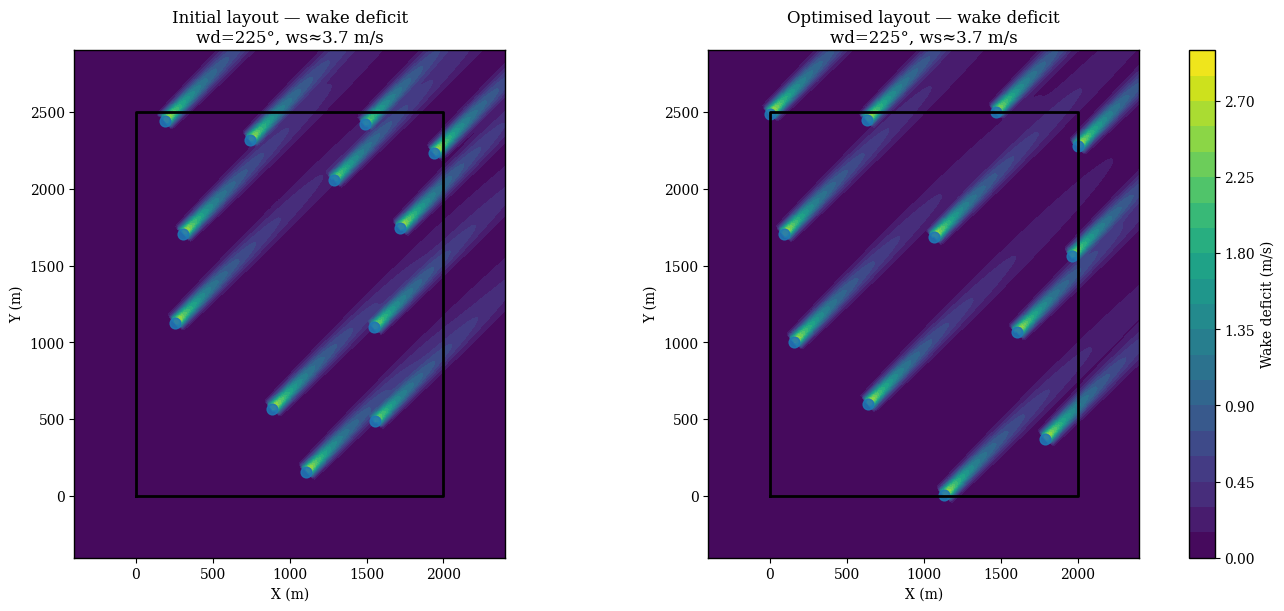

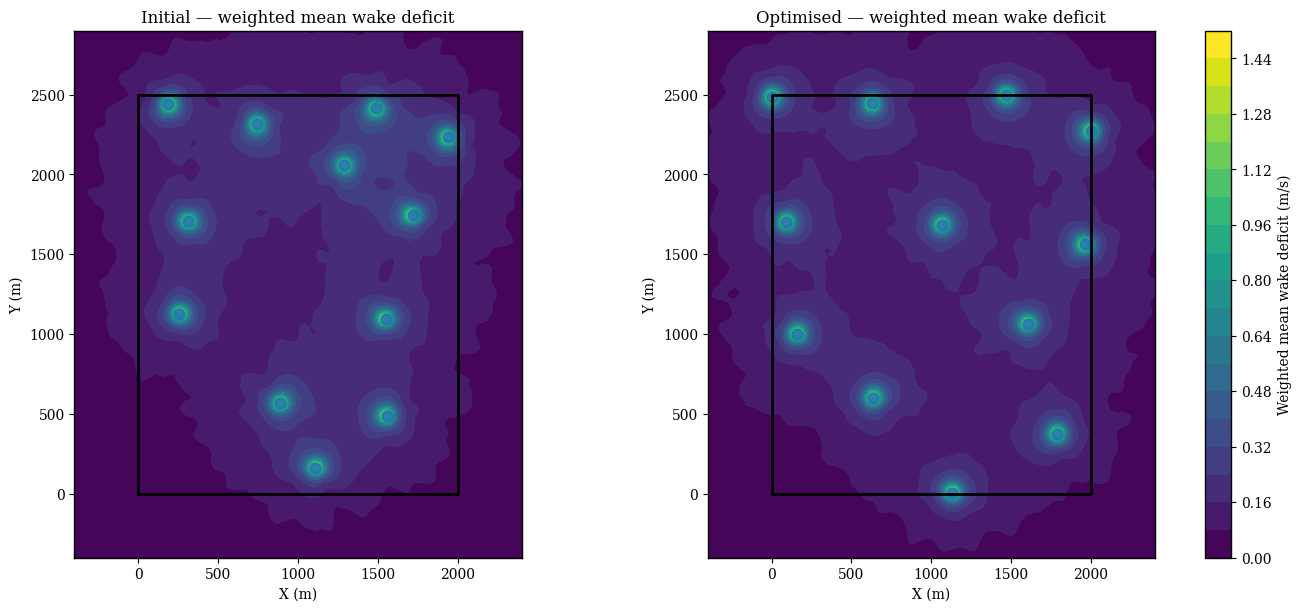

In [35]:

from scipy.special import gamma
from py_wake.flow_map import HorizontalGrid
def _require(names):
    missing = [n for n in names if n not in globals()]
    if missing:
        raise RuntimeError(
            "Missing required variables: "
            + ", ".join(missing)
            + ". Make sure the optimisation cell has run successfully."
        )

_require([
    'p_wd', 'wd_bins', 'weibull_scale_hub', 'weibull_shape_ref',
    'rotor_diameter', 'hub_height', 'x_min', 'x_max', 'y_min', 'y_max',
    'boundary', 'windFarmModel', 'x_initial', 'y_initial', 'state'
])

# 1) Direction to show and wind speed for visualisation
wd_show = float(225.0 if np.std(p_wd) < 1e-2 else wd_bins[int(np.argmax(p_wd))])
ws_show = float(weibull_scale_hub * gamma(1 + 1/weibull_shape_ref))

# 2) Grid over/around the site
pad = max(2*rotor_diameter, 400.0)
gx = np.linspace(x_min - pad, x_max + pad, 220)
gy = np.linspace(y_min - pad, y_max + pad, 220)
grid = HorizontalGrid(x=gx, y=gy, h=hub_height)

# ---- Helper functions ----
def _flow_map_for(wfm, x, y, wd, ws, grid):
    sim_res = wfm(x=x, y=y, wd=[wd], ws=[ws])
    return sim_res.flow_map(grid)

def _deficit_from_flowmap(fm):
    for name_eff, name_free in [('WS_eff_ilk','WS_ilk'), ('WS_eff','WS')]:
        if hasattr(fm, name_eff) and hasattr(fm, name_free):
            ws_eff = getattr(fm, name_eff).squeeze()
            ws0    = getattr(fm, name_free).squeeze()
            return ws0 - ws_eff
    if hasattr(fm, 'deficit_ilk'):
        return fm.deficit_ilk.squeeze()
    raise AttributeError("Could not extract wake deficit from FlowMap (PyWake version mismatch).")

def plot_wake_map_for_layout(ax, x, y, title, show='deficit'):
    """Plot wake map and return the contour mappable for colourbar."""
    fm = _flow_map_for(windFarmModel, x, y, wd_show, ws_show, grid)
    boundary_closed = np.array(boundary + [boundary[0]])

    try:
        if show == 'deficit':
            im = fm.plot_wake_map(ax=ax, deficit_or_ws='deficit', levels=21)
        else:
            im = fm.plot_wake_map(ax=ax, deficit_or_ws='ws', levels=21)
    except Exception:
        if show == 'deficit':
            Z = _deficit_from_flowmap(fm)
            im = ax.contourf(gx, gy, Z, levels=21)
        else:
            if hasattr(fm, 'WS_eff'):
                Z = fm.WS_eff.squeeze()
            elif hasattr(fm, 'WS_eff_ilk'):
                Z = fm.WS_eff_ilk.squeeze()
            else:
                raise AttributeError("FlowMap lacks WS_eff for 'ws' plotting.")
            im = ax.contourf(gx, gy, Z, levels=21)

    ax.plot(boundary_closed[:, 0], boundary_closed[:, 1], 'k-', linewidth=2)
    ax.scatter(x, y, s=60, marker='o', alpha=0.9)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    return im


fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

im0 = plot_wake_map_for_layout(
    axes[0], x_initial, y_initial,
    f'Initial layout — wake deficit\nwd={wd_show:.0f}°, ws≈{ws_show:.1f} m/s'
)
im1 = plot_wake_map_for_layout(
    axes[1], state['x'], state['y'],
    f'Optimised layout — wake deficit\nwd={wd_show:.0f}°, ws≈{ws_show:.1f} m/s'
)


cbar = fig.colorbar(im1, ax=axes, location='right', fraction=0.046, pad=0.04)
cbar.set_label('Wake deficit (m/s)')

plt.savefig('wake_maps_initial_vs_optimised.png', dpi=300, bbox_inches='tight')
plt.show()


do_weighted_map = True
if do_weighted_map:
    def weighted_deficit_map(x, y):
        acc = None
        for wd, w in zip(wd_bins, p_wd):
            fm = _flow_map_for(windFarmModel, x, y, float(wd), ws_show, grid)
            d = _deficit_from_flowmap(fm)
            acc = d * w if acc is None else acc + d * w
        return acc

    d_init = weighted_deficit_map(x_initial, y_initial)
    d_opt  = weighted_deficit_map(state['x'], state['y'])

    vmin = min(d_init.min(), d_opt.min())
    vmax = max(d_init.max(), d_opt.max())

    fig2, (axL, axR) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    c0 = axL.contourf(gx, gy, d_init, levels=21, vmin=vmin, vmax=vmax)
    c1 = axR.contourf(gx, gy, d_opt,  levels=21, vmin=vmin, vmax=vmax)

    # Shared colourbar outside (right)
    cbar2 = fig2.colorbar(c1, ax=[axL, axR], location='right', fraction=0.046, pad=0.04)
    cbar2.set_label('Weighted mean wake deficit (m/s)')

    boundary_closed = np.array(boundary + [boundary[0]])
    for ax, x_, y_, t in [(axL, x_initial, y_initial, 'Initial'),
                          (axR, state['x'], state['y'], 'Optimised')]:
        ax.plot(boundary_closed[:, 0], boundary_closed[:, 1], 'k-', linewidth=2)
        ax.scatter(x_, y_, s=60, alpha=0.9)
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f'{t} — weighted mean wake deficit')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')

    plt.savefig('wake_maps_weighted_mean_deficit.png', dpi=300, bbox_inches='tight')
    plt.show()



In [36]:


def aep_with_wake(x, y):
    """Farm AEP including wakes (GWh)."""
    return windFarmModel(x, y, wd=wd_bins).aep().sum()

def aep_no_wake_sum_of_singles(x, y):
    """
    No-wake baseline: sum AEP of each turbine simulated alone (no interactions).
    Uses the same site, turbine, wind rose, and integration.
    """
    total = 0.0
    for xi, yi in zip(np.atleast_1d(x), np.atleast_1d(y)):
        sr = windFarmModel(np.array([xi]), np.array([yi]), wd=wd_bins)
        total += sr.aep().sum()
    return total

# AEPs
init_with   = aep_with_wake(x_initial, y_initial)
opt_with    = aep_with_wake(state['x'], state['y'])
init_nowake = aep_no_wake_sum_of_singles(x_initial, y_initial)
opt_nowake  = aep_no_wake_sum_of_singles(state['x'], state['y'])

# Wake losses (GWh and % of no-wake)
init_loss_GWh = init_nowake - init_with
opt_loss_GWh  = opt_nowake  - opt_with
init_loss_pct = (init_loss_GWh / init_nowake) * 100 if init_nowake > 0 else np.nan
opt_loss_pct  = (opt_loss_GWh  / opt_nowake)  * 100 if opt_nowake  > 0 else np.nan

# Improvements
loss_reduction_GWh = init_loss_GWh - opt_loss_GWh
loss_reduction_pctpts = init_loss_pct - opt_loss_pct


print(f"Initial AEP (no-wake)     : {init_nowake:8.2f} GWh")
print(f"Initial AEP (with wakes)  : {init_with:8.2f} GWh")
print(f"Initial wake loss         : {init_loss_GWh:8.2f} GWh ({init_loss_pct:.1f}%)\n")

print(f"Optimised AEP (no-wake)   : {opt_nowake:8.2f} GWh")
print(f"Optimised AEP (with wakes): {opt_with:8.2f} GWh")
print(f"Optimised wake loss       : {opt_loss_GWh:8.2f} GWh ({opt_loss_pct:.1f}%)\n")

print(f"Wake loss reduction       : {loss_reduction_GWh:8.2f} GWh "
      f"({loss_reduction_pctpts:.1f} percentage points)")



Initial AEP (no-wake)     :    48.34 GWh
Initial AEP (with wakes)  :    44.13 GWh
Initial wake loss         :     4.21 GWh (8.7%)

Optimised AEP (no-wake)   :    48.34 GWh
Optimised AEP (with wakes):    45.19 GWh
Optimised wake loss       :     3.16 GWh (6.5%)

Wake loss reduction       :     1.05 GWh (2.2 percentage points)


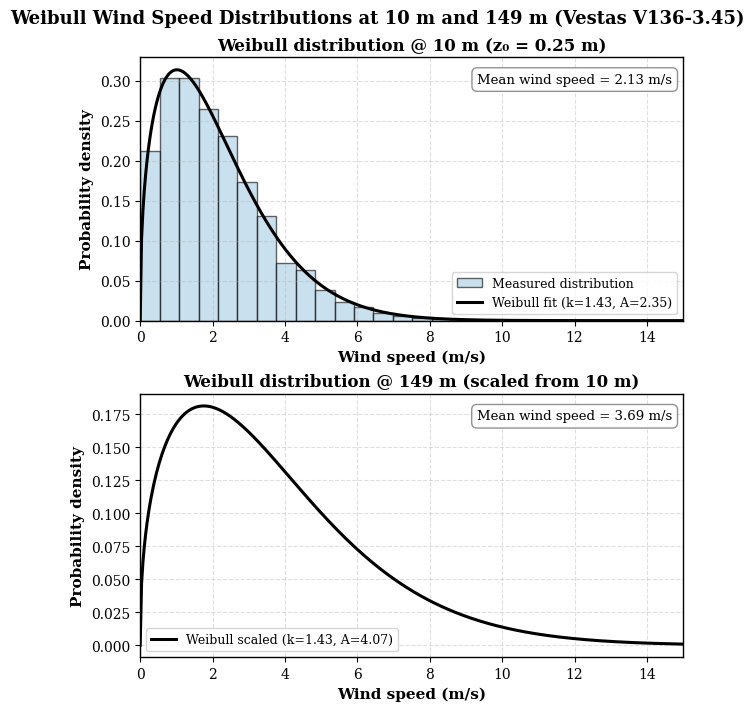

In [37]:


from scipy.stats import weibull_min
from scipy.special import gamma
import matplotlib.ticker as ticker


h_ref = 10
h_vestas = 149
z0 = surface_roughness

k = weibull_shape
A_ref = weibull_scale

A_vestas = A_ref * (np.log(h_vestas / z0) / np.log(h_ref / z0))


mean_ref = A_ref * gamma(1 + 1 / k)
mean_vestas = A_vestas * gamma(1 + 1 / k)


x = np.linspace(0, 15, 400)
pdf_ref = weibull_min.pdf(x, k, scale=A_ref)
pdf_vestas = weibull_min.pdf(x, k, scale=A_vestas)


plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 1.0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.2, 7.0), constrained_layout=True)


ax1.hist(
    weibull_min.rvs(k, scale=A_ref, size=5000),
    bins=20,
    density=True,
    color="#A6CEE3",
    edgecolor="black",
    alpha=0.6,
    label=f"Measured distribution"
)
ax1.plot(x, pdf_ref, "k-", lw=2.2, label=f"Weibull fit (k={k:.2f}, A={A_ref:.2f})")
ax1.text(
    0.98, 0.94,
    f"Mean wind speed = {mean_ref:.2f} m/s",
    transform=ax1.transAxes,
    fontsize=9.5,
    ha='right', va='top',
    bbox=dict(facecolor='white', edgecolor='grey', alpha=0.85, boxstyle='round,pad=0.4')
)
ax1.set_xlim(0, 15)
ax1.set_xlabel("Wind speed (m/s)", fontsize=11, fontweight='bold')
ax1.set_ylabel("Probability density", fontsize=11, fontweight='bold')
ax1.set_title(f"Weibull distribution @ {h_ref} m (z₀ = {z0} m)", fontsize=12, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend(fontsize=9)
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))


ax2.plot(x, pdf_vestas, "k-", lw=2.2, label=f"Weibull scaled (k={k:.2f}, A={A_vestas:.2f})")
ax2.text(
    0.98, 0.94,
    f"Mean wind speed = {mean_vestas:.2f} m/s",
    transform=ax2.transAxes,
    fontsize=9.5,
    ha='right', va='top',
    bbox=dict(facecolor='white', edgecolor='grey', alpha=0.85, boxstyle='round,pad=0.4')
)
ax2.set_xlim(0, 15)
ax2.set_xlabel("Wind speed (m/s)", fontsize=11, fontweight='bold')
ax2.set_ylabel("Probability density", fontsize=11, fontweight='bold')
ax2.set_title(f"Weibull distribution @ {h_vestas} m (scaled from {h_ref} m)", fontsize=12, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.legend(fontsize=9)
ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

fig.suptitle(
    f"Weibull Wind Speed Distributions at 10 m and {h_vestas} m (Vestas V136-3.45)",
    fontsize=13, fontweight='bold'
)

plt.savefig("weibull_10m_vs_149m_vestas.png", dpi=300, bbox_inches='tight')
plt.show()

